In [ ]:
#importing libraries
import gensim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import zipfile
from zipfile import ZipFile as zp
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d rajatkumar30/fake-news

Dataset URL: https://www.kaggle.com/datasets/rajatkumar30/fake-news
License(s): DbCL-1.0
  0% 0.00/11.5M [00:00<?, ?B/s]
100% 11.5M/11.5M [00:00<00:00, 235MB/s]


In [ ]:
uzp = zp('/content/fake-news.zip','r')
uzp.extractall()
uzp.close()

In [ ]:
data_1 = pd.read_csv('/content/news.csv')

In [ ]:
(f'Total datapoints in train-data is :{data_1.shape}')

'Total datapoints in train-data is :(6335, 4)'

In [ ]:
#viewing first few entries of data
data_1.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [ ]:
# viewing last few entries of data
data_1.tail()

,Unnamed: 0,title,text,label
6330,4490,State Department says it can't find emails fro...,The State Department told the Republican Natio...,REAL
6331,8062,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,FAKE
6332,8622,Anti-Trump Protesters Are Tools of the Oligarc...,Anti-Trump Protesters Are Tools of the Oligar...,FAKE
6333,4021,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...",REAL
6334,4330,Jeb Bush Is Suddenly Attacking Trump. Here's W...,Jeb Bush Is Suddenly Attacking Trump. Here's W...,REAL


In [ ]:
h=data_1.duplicated().sum()
print('Total no of duplicates in data:',h)

Total no of duplicates in data: 0


In [ ]:
# check for more info about data
data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  6335 non-null   int64 
 1   title       6335 non-null   object
 2   text        6335 non-null   object
 3   label       6335 non-null   object
dtypes: int64(1), object(3)
memory usage: 198.1+ KB


In [ ]:
data_1.isna().sum()

,0
Unnamed: 0,0
title,0
text,0
label,0


In [ ]:
data_1.dtypes

,0
Unnamed: 0,int64
title,object
text,object
label,object


In [ ]:
data_1['label'].value_counts()

,count
label,
REAL,3171
FAKE,3164


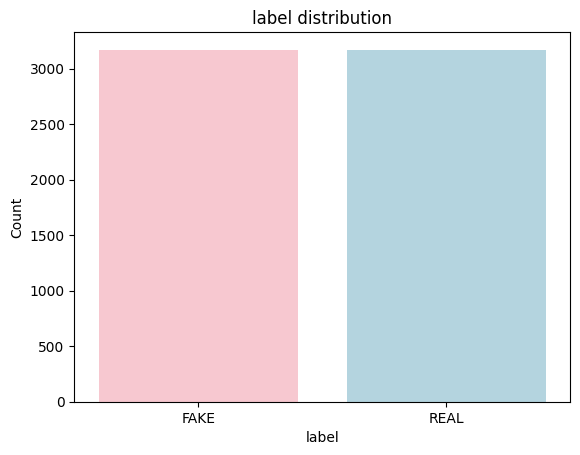

In [ ]:
sns.countplot(x=data_1['label'],palette=['pink','lightblue'])
plt.title('label distribution')
plt.xlabel('label')
plt.ylabel('Count')
plt.show()

from the above chart we can see that data is highly balaned

In [ ]:
data_1['label'] = data_1['label'].replace({'FAKE':0,'REAL':1})
data = data_1.drop(['Unnamed: 0'],axis=1)

In [ ]:
X = data.drop('label',axis=1)
Y = data['label']

**Now, we work on the train data to extract features that can be used while modeling to get better results**

**Some featurization techniques that we're going to be trying on the title and body**

1. Tf-idf - Evaluates how relevant a word is to a document in a collection of documents.
2. Word2Vec - uses a neural network model to learn word associations from a large corpus of text. Takes into consideration the semantic meaning

# Tf-idf feature extraction for the text

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# vectorizing title data
title_idf = TfidfVectorizer(
    stop_words='english',
    max_df=0.85,
    min_df=5,
    max_features=5000,
    ngram_range=(2,2)
)

title_num = title_idf.fit_transform(X['title'])
print('shape after getting tfidf values,',title_num.shape)

shape after getting tfidf values, (6335, 327)


In [ ]:
# vectorizing text data
txt_idf = TfidfVectorizer(
    stop_words='english',
    max_df=0.85,
    min_df=5,
    max_features=5000,
    ngram_range=(2,2)
)

txt_num = txt_idf.fit_transform(X['text'])
print('shape after getting tfidf values',txt_num.shape)

shape after getting tfidf values (6335, 5000)


In [ ]:
# combining the features so it can be used to feed the model

import scipy


from scipy.sparse import hstack

final_feature = hstack([title_num, txt_num])
print('the shape of the combined data after combining the tfidf body and title features:',final_feature.shape)

the shape of the combined data after combining the tfidf body and title features: (6335, 5327)


# Word2Vec on Title

Training the Word2Vec model on our corpus to extract **features**

In [ ]:
data.head()

,title,text,label
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",0
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,0
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,1
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",0
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,1


In [ ]:
#this function will remove all special marks punctuation and stopword from text and return a list of words


def conv_to_num(text):
  words = re.sub('[^a-zA-Z]',' ',text)
  words = words.lower()
  words = word_tokenize(words)
  word = [word for word in words if word not in stopwords.words('english')]
  return word

In [ ]:
data['clean_tit'] = data['title'].apply(conv_to_num)
data['clean_txt'] = data['text'].apply(conv_to_num)

In [ ]:
data.head()

,title,text,label,clean_tit,clean_txt
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",0,"[smell, hillary, fear]","[daniel, greenfield, shillman, journalism, fel..."
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,0,"[watch, exact, moment, paul, ryan, committed, ...","[google, pinterest, digg, linkedin, reddit, st..."
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,1,"[kerry, go, paris, gesture, sympathy]","[u, secretary, state, john, f, kerry, said, mo..."
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",0,"[bernie, supporters, twitter, erupt, anger, dn...","[kaydee, king, kaydeeking, november, lesson, t..."
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,1,"[battle, new, york, primary, matters]","[primary, day, new, york, front, runners, hill..."


In [ ]:
tit = data['clean_tit']
txt = data['clean_txt']

In [ ]:
txt

,clean_txt
0,"[daniel, greenfield, shillman, journalism, fel..."
1,"[google, pinterest, digg, linkedin, reddit, st..."
2,"[u, secretary, state, john, f, kerry, said, mo..."
3,"[kaydee, king, kaydeeking, november, lesson, t..."
4,"[primary, day, new, york, front, runners, hill..."
...,...
6330,"[state, department, told, republican, national..."
6331,"[p, pbs, stand, plutocratic, pentagon, posted,..."
6332,"[anti, trump, protesters, tools, oligarchy, re..."
6333,"[addis, ababa, ethiopia, president, obama, con..."


In [ ]:
from gensim.models import Word2Vec

title_w2v = Word2Vec(tit, min_count=2,vector_size=100, workers=4 )

In [ ]:
word = list(title_w2v.wv.index_to_key)
print(len(word))

4870


In [ ]:
print('Number of words that occured minimun 2 times',len(word))

Number of words that occured minimun 2 times 4870


In [ ]:
title_w2v.wv.most_similar('war')

[('trump', 0.9989994168281555),
 ('new', 0.9989022016525269),
 ('election', 0.9988308548927307),
 ('russia', 0.9987903833389282),
 ('gop', 0.9986866116523743),
 ('hillary', 0.9986779689788818),
 ('clinton', 0.9986685514450073),
 ('us', 0.9986532926559448),
 ('u', 0.9986088275909424),
 ('video', 0.9985784292221069)]

In [ ]:
title_w2v.wv.most_similar('election')

[('trump', 0.999392032623291),
 ('obama', 0.9992055296897888),
 ('hillary', 0.9991950392723083),
 ('new', 0.9991737008094788),
 ('police', 0.9991612434387207),
 ('us', 0.9991340041160583),
 ('russia', 0.999125599861145),
 ('america', 0.9991254210472107),
 ('isis', 0.9991205334663391),
 ('gop', 0.9990999102592468)]

In [ ]:
def sent_to_vector(words, model):
  word_vecs = [model.wv[word] for word in words if word in model.wv]
  if word_vecs:
    return np.mean(word_vecs, axis=0)
  else:
    return np.zeros(model.vector_size)

    X = np.array([sent_to_vector(text, title_w2v)for text in review_text])

In [ ]:

X = np.array([sent_to_vector(text, title_w2v)for text in tit])
X

array([[-0.07301871,  0.11834732,  0.05735639, ..., -0.13684513,
         0.0710699 ,  0.01077281],
       [-0.07923248,  0.11682858,  0.06283168, ..., -0.14438173,
         0.06705816,  0.01549028],
       [-0.02724276,  0.03729443,  0.02212932, ..., -0.05271977,
         0.02173914,  0.00617109],
       ...,
       [-0.06465516,  0.10365693,  0.05617649, ..., -0.12812249,
         0.05859943,  0.01290948],
       [-0.04209498,  0.06004463,  0.03202623, ..., -0.07363909,
         0.03787759,  0.0063736 ],
       [-0.07533541,  0.11117903,  0.06491449, ..., -0.14085968,
         0.06169639,  0.01259149]])

**Word2Vec on Body**

In [ ]:

text_w2v = Word2Vec(txt, min_count=3, vector_size=100, workers=4)

In [ ]:
bodyword = list(text_w2v.wv.index_to_key)
print(len(bodyword))

34494


In [ ]:
print('Number of words that occur minimun 3 times',len(bodyword))

Number of words that occur minimun 3 times 34494


In [ ]:
text_w2v.wv.most_similar('trump')

[('businessman', 0.6483164429664612),
 ('interrupt', 0.5989972352981567),
 ('rumsfeld', 0.5604174137115479),
 ('tone', 0.5559451580047607),
 ('reassured', 0.5532422661781311),
 ('mogul', 0.5417513847351074),
 ('billionaire', 0.5346317291259766),
 ('romney', 0.5339775681495667),
 ('confounded', 0.5318859219551086),
 ('conway', 0.5317592024803162)]

In [ ]:
text_w2v.wv.most_similar('war')

[('invasion', 0.7179538011550903),
 ('wars', 0.6702970266342163),
 ('unrest', 0.6130359768867493),
 ('invading', 0.6123696565628052),
 ('invade', 0.585421621799469),
 ('syria', 0.5715357065200806),
 ('afghanistan', 0.5555508136749268),
 ('disobedience', 0.5481716394424438),
 ('invaded', 0.5417874455451965),
 ('intervention', 0.536981463432312)]

In [ ]:
def conv_to_numb(senta, model):
  word_vocab = [text_w2v.wv[word] for word in senta if word in text_w2v.wv]
  if word_vocab:
    return np.mean(word_vocab, axis=0)
  else:
    return np.zeros(text_w2v.vector_size)



In [ ]:
X2 = np.array([conv_to_numb(text, text_w2v) for text in txt])
X2

array([[-0.01290386,  0.44847807, -0.214307  , ..., -0.14829431,
         0.30031434,  0.26814187],
       [-0.46166429,  0.52976823, -0.05239014, ..., -0.19014655,
         0.36961448,  0.34953395],
       [-0.31398416,  0.14872356,  0.00868949, ..., -0.27092317,
         0.22742027, -0.01078719],
       ...,
       [-0.23815037,  0.18887177, -0.21805733, ..., -0.16066673,
         0.06209224,  0.24382673],
       [-0.25506076,  0.11062501, -0.16745499, ..., -0.21545491,
        -0.14808781,  0.04323721],
       [-0.44372869,  0.59414035, -0.05855887, ..., -0.12592521,
         0.40802106,  0.47141576]])

In [ ]:
# combining both features
final_features = np.hstack([X,X2])
final_features

array([[-0.07301871,  0.11834732,  0.05735639, ..., -0.14829431,
         0.30031434,  0.26814187],
       [-0.07923248,  0.11682858,  0.06283168, ..., -0.19014655,
         0.36961448,  0.34953395],
       [-0.02724276,  0.03729443,  0.02212932, ..., -0.27092317,
         0.22742027, -0.01078719],
       ...,
       [-0.06465516,  0.10365693,  0.05617649, ..., -0.16066673,
         0.06209224,  0.24382673],
       [-0.04209498,  0.06004463,  0.03202623, ..., -0.21545491,
        -0.14808781,  0.04323721],
       [-0.07533541,  0.11117903,  0.06491449, ..., -0.12592521,
         0.40802106,  0.47141576]])

In [ ]:
# spiliting for word2vec data
X_train_w2v, X_test_w2v, Y_train_w2v, Y_test_w2v = train_test_split(final_features, Y, test_size=0.2,stratify=Y, random_state=32)

X_train_w2v.shape, X_test_w2v.shape

((5068, 200), (1267, 200))

# Using Machine Learning Models

Now that the data has been cleaned using techniques like TFIDF and Word2Vec, the last and final stage in the pipeline is to train a Machine Learning model on the data. The data was initially in the form of title and body which was then converted to a combined sparse matrix representation.

In [ ]:
from sklearn.model_selection import train_test_split

# spiliting for tfidf vectorize data
X_train, X_test, Y_train, Y_test = train_test_split(final_feature,Y,test_size=0.1, stratify=Y, random_state=32)

X_train.shape, X_test.shape

((5701, 5327), (634, 5327))

In [ ]:
def train_model(classifier, X_train, X_test, Y_train, Y_test):
  classifier.fit(X_train, Y_train)

  train_pre = classifier.predict(X_train)
  print('Train set report')
  print(classification_report(Y_train, train_pre))



  print('********************************************')



  test_pre = classifier.predict(X_test)
  print('test set report')
  print(classification_report(Y_test, test_pre))

  print('-------------------------------------------')
  print('train accuracy:',accuracy_score(Y_train, train_pre))
  print('test accuracy:',accuracy_score(Y_test, test_pre))
  print('---------------------------------------------')

  cm=confusion_matrix(Y_test, test_pre)
  plt.figure(figsize=(6,4))
  sns.heatmap(cm, annot=True, fmt='d',cmap='Blues')
  plt.title('Confusion Matrix')
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.show()


  return classifier




# Using Tfidf vectorization

**Multinomial Naive Bayes**

In [ ]:
from sklearn.naive_bayes import MultinomialNB

clf_nb = MultinomialNB()

Train set report
              precision    recall  f1-score   support

           0       0.93      0.92      0.93      2847
           1       0.92      0.93      0.93      2854

    accuracy                           0.93      5701
   macro avg       0.93      0.93      0.93      5701
weighted avg       0.93      0.93      0.93      5701

********************************************
test set report
              precision    recall  f1-score   support

           0       0.92      0.89      0.90       317
           1       0.89      0.93      0.91       317

    accuracy                           0.91       634
   macro avg       0.91      0.91      0.91       634
weighted avg       0.91      0.91      0.91       634

-------------------------------------------
train accuracy: 0.9259778986142781
test accuracy: 0.9069400630914827
---------------------------------------------


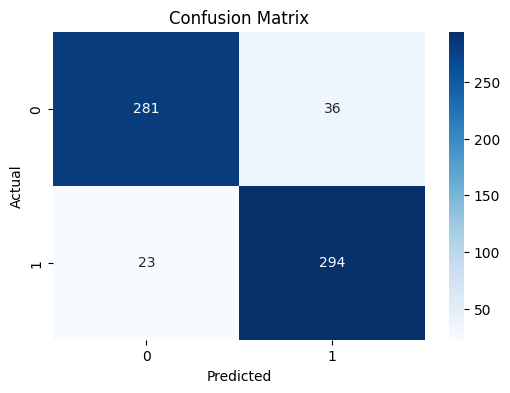

MultinomialNB()

In [ ]:
train_model(clf_nb, X_train, X_test, Y_train, Y_test)

**Logistic Regression**

In [ ]:
from sklearn.linear_model import LogisticRegression

clf_lr = LogisticRegression()

Train set report
              precision    recall  f1-score   support

           0       0.94      0.97      0.96      2847
           1       0.97      0.94      0.96      2854

    accuracy                           0.96      5701
   macro avg       0.96      0.96      0.96      5701
weighted avg       0.96      0.96      0.96      5701

********************************************
test set report
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       317
           1       0.94      0.92      0.93       317

    accuracy                           0.93       634
   macro avg       0.93      0.93      0.93       634
weighted avg       0.93      0.93      0.93       634

-------------------------------------------
train accuracy: 0.9577267146114716
test accuracy: 0.9290220820189274
---------------------------------------------


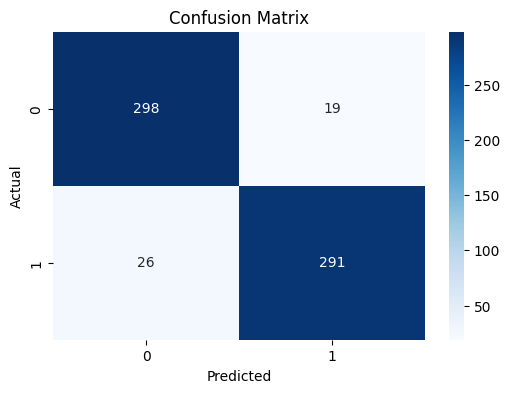

LogisticRegression()

In [ ]:
train_model(clf_lr, X_train, X_test, Y_train, Y_test)

**Random Forest Classifier**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf_ran = RandomForestClassifier()

Train set report
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2847
           1       1.00      0.99      0.99      2854

    accuracy                           0.99      5701
   macro avg       0.99      0.99      0.99      5701
weighted avg       0.99      0.99      0.99      5701

********************************************
test set report
              precision    recall  f1-score   support

           0       0.92      0.89      0.90       317
           1       0.89      0.92      0.91       317

    accuracy                           0.91       634
   macro avg       0.91      0.91      0.91       634
weighted avg       0.91      0.91      0.91       634

-------------------------------------------
train accuracy: 0.9936853183651991
test accuracy: 0.9053627760252366
---------------------------------------------


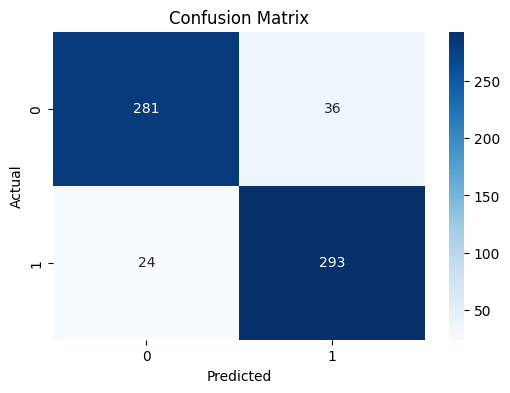

RandomForestClassifier()

In [ ]:
train_model(clf_ran, X_train, X_test, Y_train, Y_test)

In [ ]:
from lightgbm import LGBMClassifier

clf_lig = LGBMClassifier()

[LightGBM] [Info] Number of positive: 2854, number of negative: 2847
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.333648 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 63868
[LightGBM] [Info] Number of data points in the train set: 5701, number of used features: 3834
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500614 -> initscore=0.002456
[LightGBM] [Info] Start training from score 0.002456
Train set report
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      2847
           1       0.99      0.95      0.97      2854

    accuracy                           0.97      5701
   macro avg       0.97      0.97      0.97      5701
weighted avg       0.97      0.97      0.97      5701

********************************************
test set report
              precision    recall  f1-s

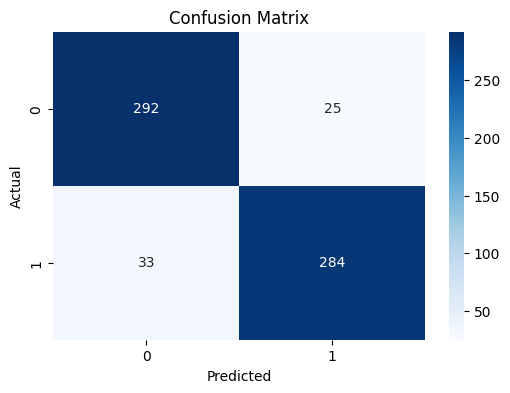

LGBMClassifier()

In [ ]:
train_model(clf_lig, X_train, X_test, Y_train, Y_test)

**Support Vector Classifier**

In [ ]:
from sklearn.svm import SVC

clf_sv = SVC()

Train set report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2847
           1       1.00      0.98      0.99      2854

    accuracy                           0.99      5701
   macro avg       0.99      0.99      0.99      5701
weighted avg       0.99      0.99      0.99      5701

********************************************
test set report
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       317
           1       0.93      0.93      0.93       317

    accuracy                           0.93       634
   macro avg       0.93      0.93      0.93       634
weighted avg       0.93      0.93      0.93       634

-------------------------------------------
train accuracy: 0.9887738993159095
test accuracy: 0.9274447949526814
---------------------------------------------


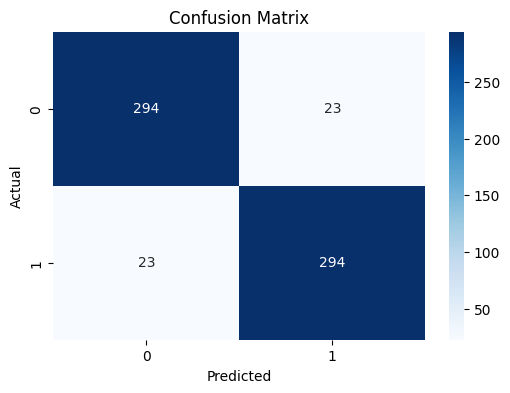

SVC()

In [ ]:
train_model(clf_sv, X_train, X_test, Y_train,Y_test)

Conclusiom and Takeaways:


*   Logistic Regression outperforms all the other models.
*   With SVC we are getting a test acccuracy of about 92.74%
*   With Logistic Regression we are getting a test accuracy of about 92.90%



# **Using Word2Vec**

In [ ]:
from sklearn.naive_bayes import MultinomialNB

clf_mn2 = MultinomialNB()

Train set report
              precision    recall  f1-score   support

           0       0.93      0.92      0.93      2847
           1       0.92      0.93      0.93      2854

    accuracy                           0.93      5701
   macro avg       0.93      0.93      0.93      5701
weighted avg       0.93      0.93      0.93      5701

********************************************
test set report
              precision    recall  f1-score   support

           0       0.92      0.89      0.90       317
           1       0.89      0.93      0.91       317

    accuracy                           0.91       634
   macro avg       0.91      0.91      0.91       634
weighted avg       0.91      0.91      0.91       634

-------------------------------------------
train accuracy: 0.9259778986142781
test accuracy: 0.9069400630914827
---------------------------------------------


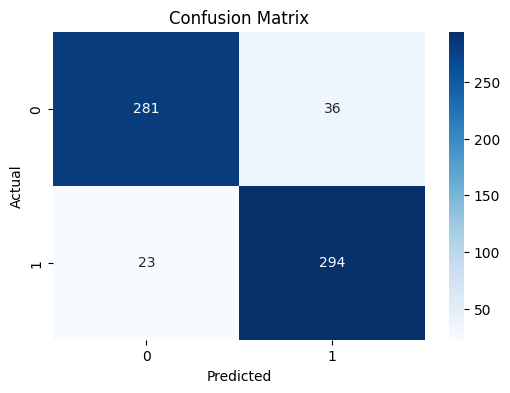

MultinomialNB()

In [ ]:
train_model(clf_mn2, X_train, X_test, Y_train, Y_test)

In [ ]:
clf_lr2 = LogisticRegression()

Train set report
              precision    recall  f1-score   support

           0       0.89      0.90      0.89      2531
           1       0.90      0.89      0.89      2537

    accuracy                           0.89      5068
   macro avg       0.89      0.89      0.89      5068
weighted avg       0.89      0.89      0.89      5068

********************************************
test set report
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       633
           1       0.88      0.88      0.88       634

    accuracy                           0.88      1267
   macro avg       0.88      0.88      0.88      1267
weighted avg       0.88      0.88      0.88      1267

-------------------------------------------
train accuracy: 0.8924625098658248
test accuracy: 0.8784530386740331
---------------------------------------------


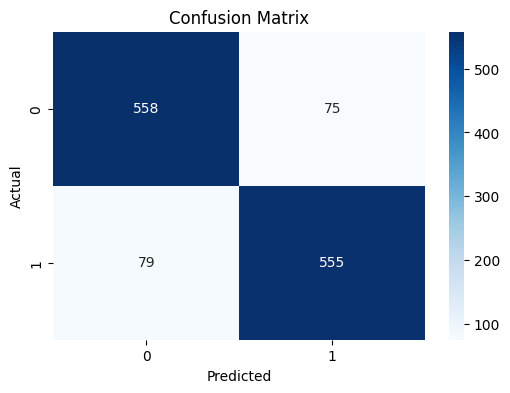

LogisticRegression()

In [ ]:
train_model(clf_lr2, X_train_w2v, X_test_w2v, Y_train_w2v, Y_test_w2v)

In [ ]:
clf_sv2 = SVC()

Train set report
              precision    recall  f1-score   support

           0       0.91      0.92      0.91      2531
           1       0.92      0.90      0.91      2537

    accuracy                           0.91      5068
   macro avg       0.91      0.91      0.91      5068
weighted avg       0.91      0.91      0.91      5068

********************************************
test set report
              precision    recall  f1-score   support

           0       0.89      0.89      0.89       633
           1       0.89      0.89      0.89       634

    accuracy                           0.89      1267
   macro avg       0.89      0.89      0.89      1267
weighted avg       0.89      0.89      0.89      1267

-------------------------------------------
train accuracy: 0.9127861089187056
test accuracy: 0.8902920284135754
---------------------------------------------


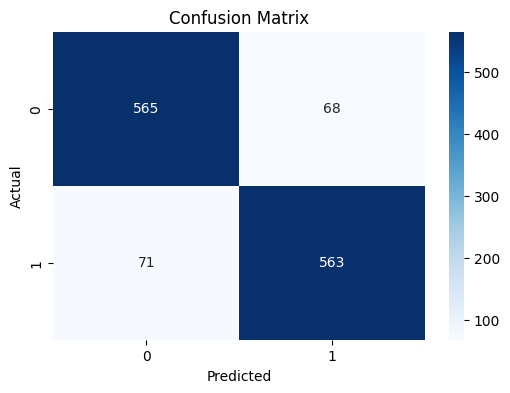

SVC()

In [ ]:
train_model(clf_sv2, X_train_w2v, X_test_w2v, Y_train_w2v, Y_test_w2v)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

clf_lig2 = KNeighborsClassifier()

Train set report
              precision    recall  f1-score   support

           0       0.93      0.90      0.91      2531
           1       0.90      0.93      0.92      2537

    accuracy                           0.91      5068
   macro avg       0.92      0.91      0.91      5068
weighted avg       0.92      0.91      0.91      5068

********************************************
test set report
              precision    recall  f1-score   support

           0       0.91      0.86      0.88       633
           1       0.87      0.91      0.89       634

    accuracy                           0.89      1267
   macro avg       0.89      0.89      0.89      1267
weighted avg       0.89      0.89      0.89      1267

-------------------------------------------
train accuracy: 0.914956590370955
test accuracy: 0.8855564325177585
---------------------------------------------


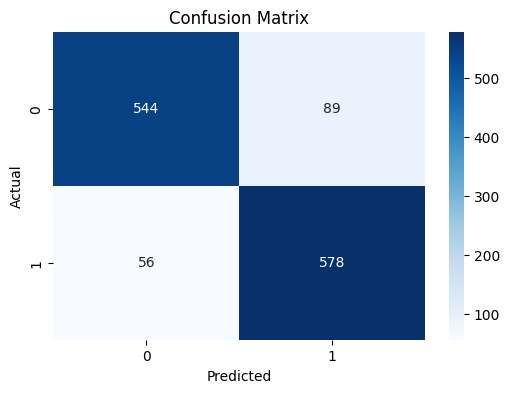

KNeighborsClassifier()

In [ ]:
train_model(clf_lig2, X_train_w2v, X_test_w2v, Y_train_w2v, Y_test_w2v)

# **Takeaways**


*   Logistic Regression when paired with TFIDF and biagrams yield the best test scores.
*   its is clear that linear models works really well with high dimensionality and can even outperform tree based classifiers

